In [1]:
%load_ext lab_black

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima

In [3]:
data = pd.read_csv("../data/combined.csv").set_index("date")

In [4]:
gas_price = data["gas_price"]

lin1 = gas_price + (gas_price - gas_price.shift(1))
lin10 = gas_price + (gas_price - gas_price.shift(10)) / 10

In [5]:
def ols(y):
    window = len(y)
    x = np.linspace(0, window, window)
    stdx = np.std(x)
    stdx = stdx if stdx else 1
    stdy = np.std(y)
    r = np.corrcoef(y)
    beta1 = r * stdy / stdx
    beta0 = np.mean(y) - beta1 * np.mean(x)

    return beta0 + beta1 * (window + 1)


ols10 = gas_price.rolling(window=10, min_periods=2).apply(ols)

In [29]:
arima_df = data.copy()
arima_df["gas_price"] = arima_df["gas_price"].shift(1)

arima_df = arima_df.dropna()

train = arima_df.loc[:"2019-01-01"]
test = arima_df.loc["2019-01-01":]

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    arima = auto_arima(
        train["gas_price"],
        X=train[[col for col in data.columns if col != "gas_price"]],
        start_p=0,
        start_q=0,
        max_p=30,
        max_q=30,
        d=0,
        trace=True,
    )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1660.288, Time=2.64 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3386.625, Time=2.65 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2386.205, Time=3.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6668.886, Time=2.48 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-3396.735, Time=3.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-3394.793, Time=3.88 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3394.705, Time=3.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3396.546, Time=3.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3393.102, Time=4.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3398.743, Time=3.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3388.631, Time=2.52 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3396.801, Time=3.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3396.713, Time=3.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3398.555, Time=3.05 sec
 ARIMA(3,0,1)(0,0,0)

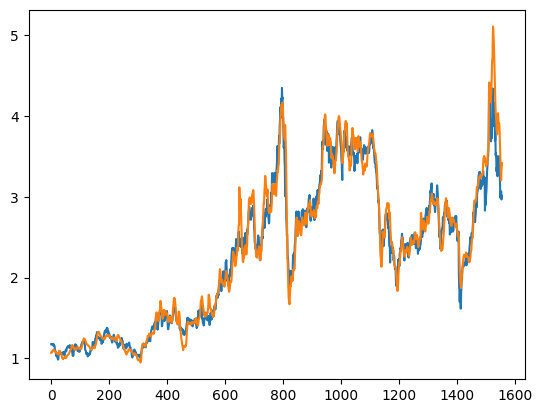

In [30]:
arima_pred = arima.predict(
    n_periods=len(arima_df),
    X=arima_df[[col for col in data.columns if col != "gas_price"]],
)

plt.plot(arima_pred.values)
plt.plot(data["gas_price"].values)

,0
2019-01-07,3.017407
2019-01-14,2.964873
2019-01-21,2.846972
2019-01-28,2.766099
2019-02-04,2.666307
2019-02-11,2.565030
2019-02-18,2.484508
2019-02-25,2.552889
2019-03-04,2.541544
2019-03-11,2.425382


date
2019-01-07    2.358
2019-01-14    2.329
2019-01-21    2.338
2019-01-28    2.340
2019-02-04    2.343
2019-02-11    2.341
2019-02-18    2.361
2019-02-25    2.400
2019-03-04    2.471
2019-03-11    2.502
Name: gas_price, dtype: float64